# Master Experiment Notebook

This notebook contains the basic structure of a test. We set up some data from our datasets, implement a simple ngmix measurement from that, and compare to  autodiff and finitediff from autometacal.

Data can have:

- some coherent shear applied to all galaxies
- some level of noise applied to them

The goal is to get (at least some of) the following experiments running:

1. How the performance compares? If we do 100 blocks of 1000 galaxies, how long does it take for autometacal, vs ngmix?
2. Can AutoMetaCal perform better than ngmix by using smaller PSFs?
3. How does Autodiff vs Finitediff vs ngmix compare with realistic galaxies?
4. How does Autodiff vs ngmix go with model fitting?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import ngmix

### Test setup

In [3]:
#global values
fixnoise = False
batch_size = 800
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 1e-3

### Data

In [4]:
from autometacal.python import datasets

In [5]:
#dataset
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.shuffle(batch_size)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Display a range of galaxy models:

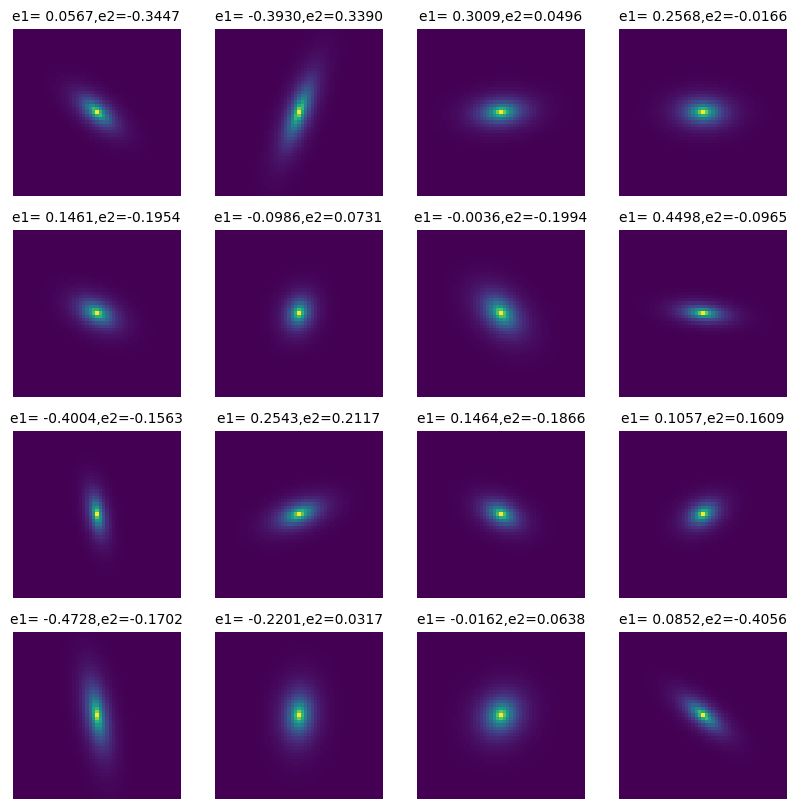

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [7]:
from autometacal.python.utils import *

In [8]:
#create 1 batch of observed images
gal_images=noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([real_shear],len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
psf_images = onebatch['psf_image']

/local/home/br263581/miniconda3/envs/gems/lib/python3.6/site-packages/tensorflow_addons/utils/resource_loader.py:110: UserWarning: You are currently using TensorFlow 2.6.2 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.7.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.7.0 and strictly below 2.8.0.
 Note that nightly versions of TensorFlow, as well 

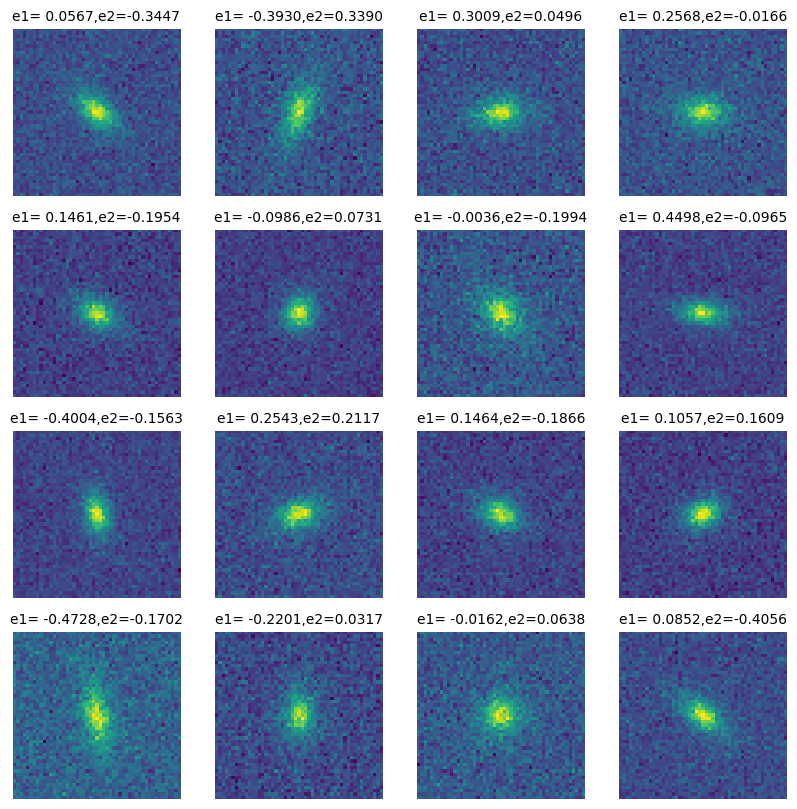

In [9]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

## Set up ngmix

In [10]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [11]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=fixnoise,
)

In [12]:
from autometacal.python.metacal import generate_mcal_image, get_metacal_response, get_metacal_response_finitediff
from autometacal.python.moments import get_moment_ellipticities, gaussian_moments

Set up functions to get responses from AMC and ngmix

In [13]:
#for ngmix
def get_metacal_response_ngmix(resdict):
  step=0.01
  """
  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  """ 
  e1, e2 = resdict['noshear']['e'][0], resdict['noshear']['e'][1]
 
  g0s = np.array([resdict['noshear']['e'][0], resdict['noshear']['e'][1]])
  g1p = np.array([resdict['1p']['e'][0], resdict['1p']['e'][1]])
  g1m = np.array([resdict['1m']['e'][0], resdict['1m']['e'][1]])
  g2p = np.array([resdict['2p']['e'][0], resdict['2p']['e'][1]])
  g2m = np.array([resdict['2m']['e'][0], resdict['2m']['e'][1]])    
    
    
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R 

#AutoMetaCal runner
method = lambda im: get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,psf_images,method)

## Shakedown Test!

Let's make a measurement on a single image.

In [14]:
im = gal_images[0]
psf_im = psf_images[0] 

In [15]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

Run one ngmix measurement:

In [16]:
resdict, obsdict = boot.go(obs)

Different Reconvolution PSFs if needed

## One Batch Test

In [308]:
#reset data
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

Testing AMC speed: 

To be fair, let's use ngmix in parallel. 

In [309]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

Testing ngmix speed:

## Selection response

Here we try a size cut as in the [ngmix example](https://github.com/esheldon/ngmix/blob/38c379013840b5a650b4b11a96761725251772f5/examples/metacal/metacal_select.py).

### Start with `ngmix` response

In [310]:
def return_resdict(im, psf):
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  return resdict, obsdict

In [311]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]

In [312]:
gnoshear = []
g1p = []
g1m = []
wnoshear = []
w1p = []
w1m = []
dlist = []
for i in range(len(gal_images)):
  resdict, obsdict = return_resdict(gal_images.numpy()[i], psf_images[i])
  #resdicts.append(resdict)
  gnoshear.append(resdict['noshear']['e'][0])
  g1p.append(resdict['1p']['e'][0])
  g1m.append(resdict['1m']['e'][0])
  wnoshear.append(resdict['noshear']['T']/obsdict['noshear'].psf.meta['result']['T'])
  w1p.append(resdict['1p']['T']/obsdict['1p'].psf.meta['result']['T'])
  w1m.append(resdict['1m']['T']/obsdict['1m'].psf.meta['result']['T'])

In [313]:
print(resdict['1m']['T'])
print(obsdict['1m'].psf.meta['result']['T'])

0.3345651598127529
0.1511612376902816


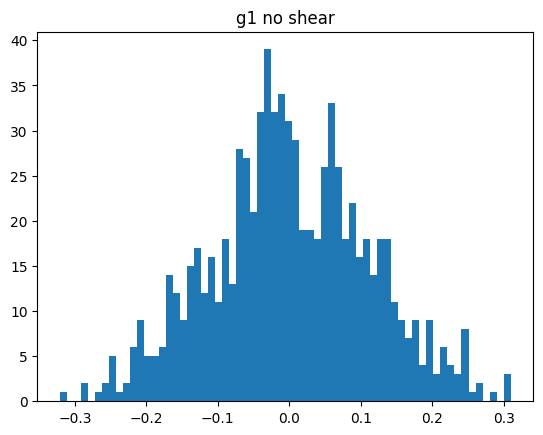

In [314]:
title('g1 no shear')
hist(gnoshear, bins=64);

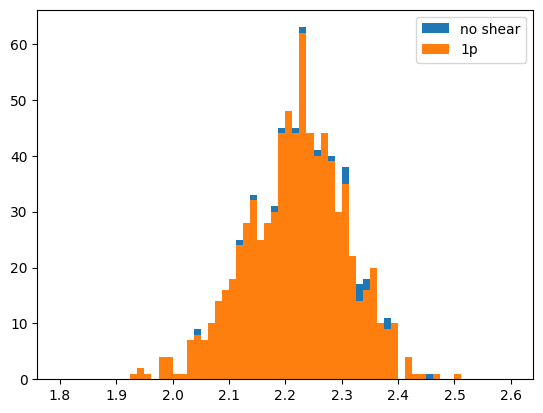

In [315]:
hist(wnoshear, bins=64, label='no shear', range=[1.8, 2.6]);
hist(w1p, bins=64, label='1p', range=[1.8, 2.6]);
legend()

In [361]:
size_cut = 2.1

In [362]:
w = np.array(wnoshear) > size_cut
w_1p = np.array(w1p) > size_cut
w_1m = np.array(w1m) > size_cut

print(tf.reduce_all(w == w_1p))
print(tf.reduce_all(w == w_1m))

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)


In [363]:
g = np.array(gnoshear)[w].mean()
gerr = np.array(gnoshear)[w].std(axis=0) / np.sqrt(w.size)
g1_1p = np.array(gnoshear)[w_1p].mean()
g1_1m = np.array(gnoshear)[w_1m].mean()
R11 = (g1_1p - g1_1m)/0.02

In [364]:
g1_1p

0.0014670073687653442

In [365]:
g1_1m

0.0014819935502289178

In [366]:
R11

-0.0007493090731786793

In [367]:
size_cut

2.1

## using finite diff

In [391]:
#@tf.function()
def get_selection_response(gal_images, psf_images, size_cut):
  step = 0.01
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gz = tf.zeros([1,2])
  #gp = step*tf.ones([1,2])
  #gm = -step*tf.ones([1,2])
  gp = step*tf.reshape(tf.convert_to_tensor([1., 0.], tf.float32), [1,2])
  gm = -step*tf.reshape(tf.convert_to_tensor([1., 0.], tf.float32), [1,2])
    
  Tpsf = get_moment_T(psf_images, scale=0.2, fwhm=1.2)

  m_imagesz = generate_mcal_image(gal_images, psf_images, psf_images, gz)
  m_imagesp = generate_mcal_image(gal_images, psf_images, psf_images, gp)
  m_imagesm = generate_mcal_image(gal_images, psf_images, psf_images, gm)

  Tp = get_moment_T(m_imagesp, scale=0.2, fwhm=1.2)
  Tm = get_moment_T(m_imagesm, scale=0.2, fwhm=1.2)  
    
  #wp = selection(T/Tpsf, size_cut, 0.01)
  #print(Tp/Tpsf)
  #'''
  wp = tf.cast(Tp/Tpsf>size_cut, tf.float32)
  wm = tf.cast(Tm/Tpsf>size_cut, tf.float32)
  '''
  wp = selection(Tp/Tpsf, size_cut, 0.001)
  wm = selection(Tm/Tpsf, size_cut, 0.001)
  '''
  print(tf.reduce_all(wp==wm))
  print(wp.shape)
  print(get_moment_ellipticities(gal_images, scale=0.2, fwhm=1.2).shape)

  ep = tf.reduce_mean(get_moment_ellipticities(m_imagesz, scale=0.2, fwhm=1.2)*tf.transpose(wp),
                   axis=0)
  em = tf.reduce_mean(get_moment_ellipticities(m_imagesz, scale=0.2, fwhm=1.2)*tf.transpose(wm),
                   axis=0)

  R = (ep-em)/(2*step)
  
  return R

In [392]:
R = get_selection_response(gal_images, psf_images, size_cut)

tf.Tensor(False, shape=(), dtype=bool)
(1, 800)
(800, 2)


In [393]:
print('R11', R[0].numpy())

R11 0.010942272


### Now using autodiff

In [371]:
#from autometacal.python.tf_ngmix.pixels import make_pixels
#from autometacal.python.tf_ngmix.gmix import fwhm_to_T
from autometacal.python.metacal import generate_mcal_image
from autometacal.python.moments import gaussian_moments
def get_moment_T(images, scale, fwhm, **kwargs):
  """
  Gets ellipticity estimates from gaussian moments of stamps.
  
  Args:
    images: tf.Tensor
      A bach of images as a (batch_size,nx,ny) tf tensor.
    scale: float
      The pixel scale of the image in arcsec/pixel.
    fwhm: float
      The full width at half maximum of the gaussian filter in arcseconds
    centre_x, centre_y: floats
     Centre of the image in pixels, if ommited, the centre pixel of the stamp is used.
    weights: tf.Tensor
      An image containing the weights of the pixels. If ommited = tf.ones(nx,ny)
    
  Returns:
    Ellipticities: tf.Tensor
      A batch of ellipticities according to the |g| = (a - b)/(a + b) convention.
    
  """  
  
  Q11, Q12, Q22  = gaussian_moments(images, scale, fwhm, **kwargs)
  
  q1 = Q11 - Q22
  q2 = 2*Q12
  T = Q11  + Q22 # e convention 
  return T 

In [372]:
from autometacal.python.moments import get_moment_ellipticities

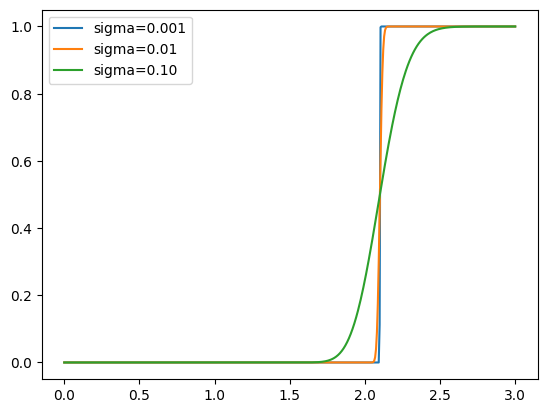

In [373]:
def selection(x, t, sigma):
  return .5 * (1 + tf.math.erf((tf.math.log(x) - tf.math.log(t))/sigma))

plot(tf.linspace(0., 3., 500), selection(tf.linspace(0., 3., 500), 2.1, 0.001), label='sigma=0.001')
plot(tf.linspace(0., 3., 500), selection(tf.linspace(0., 3., 500), 2.1, 0.01), label='sigma=0.01')
plot(tf.linspace(0., 3., 500), selection(tf.linspace(0., 3., 500), 2.1, 0.10), label='sigma=0.10')
legend()

In [381]:
@tf.function()
def get_selection_amc_response(gal_images, psf_images, size_cut):
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  g = tf.zeros([1,2])
    
  Tpsf = get_moment_T(psf_images, scale=0.2, fwhm=1.2)

  with tf.GradientTape() as tape:
    tape.watch(g)
    m_images = generate_mcal_image(gal_images, psf_images, psf_images, g)

    T = get_moment_T(m_images, scale=0.2, fwhm=1.2)
    
    w = selection(T/Tpsf, size_cut, 0.001)

    m_images = tf.stop_gradient(m_images)
    e = tf.reduce_mean(get_moment_ellipticities(m_images, scale=0.2, fwhm=1.2)*tf.transpose(w),
                   axis=0)
  
  R = tape.jacobian(e, g)
  return e, R

In [382]:
e, R = get_selection_amc_response(gal_images, psf_images, size_cut)

In [383]:
e

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.00265788, -0.00090903], dtype=float32)>

In [384]:
R

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[ 0.00975171,  0.00584807]],

       [[ 0.01528709, -0.01345462]]], dtype=float32)>

In [385]:
print(e[0])
print(R[0,0,0])
print(R[1,0,1])

tf.Tensor(0.0026578766, shape=(), dtype=float32)
tf.Tensor(0.009751715, shape=(), dtype=float32)
tf.Tensor(-0.013454616, shape=(), dtype=float32)


In [386]:
print('R11', R[0,0,0].numpy())

R11 0.009751715


In [387]:
r_amc = R

## All Batches Test